# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

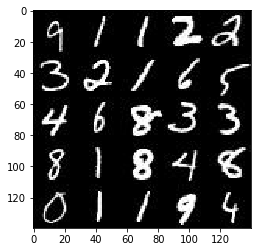

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

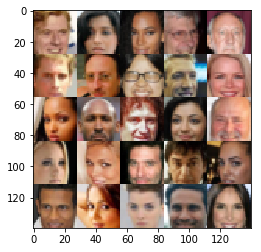

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):

        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
     
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    #d_loss_real = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
  
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) 
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    out_channel_dim = 3 if data_image_mode=="RGB" else 1
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Batch images for discriminator
                batch_images = batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real:batch_images,
                                                lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
              

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 3.2914... Generator Loss: 0.0741
Epoch 1/2... Discriminator Loss: 0.9555... Generator Loss: 4.3275
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 4.0502
Epoch 1/2... Discriminator Loss: 1.0837... Generator Loss: 0.8979
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 1.7146
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.8910
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 0.8998... Generator Loss: 1.9220
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 1.0373


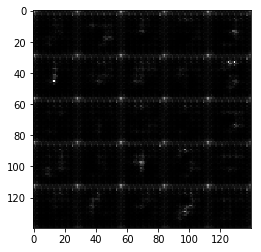

Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 1.3200
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 0.7794
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 1.1813
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.7109
Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 1.1097... Generator Loss: 1.3944
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.7062


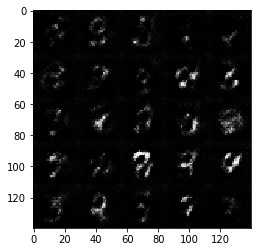

Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 0.8303
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 1.0445
Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 1.0705
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 0.8871
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 0.8319
Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 1.2020
Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 1.2103
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 1.5709
Epoch 1/2... Discriminator Loss: 1.8380... Generator Loss: 0.3193
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.8896


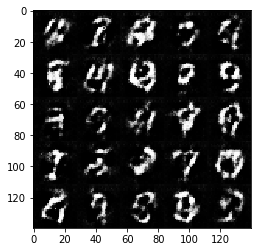

Epoch 1/2... Discriminator Loss: 1.0849... Generator Loss: 0.9223
Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 0.9819
Epoch 1/2... Discriminator Loss: 1.1099... Generator Loss: 1.1777
Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 1.6266
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 1.3999
Epoch 1/2... Discriminator Loss: 0.9980... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 1.5158
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.8519


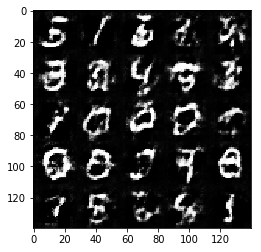

Epoch 1/2... Discriminator Loss: 1.0143... Generator Loss: 1.0907
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.7435
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.6052
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 1.1541
Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 1.2016
Epoch 1/2... Discriminator Loss: 1.4675... Generator Loss: 0.4441
Epoch 1/2... Discriminator Loss: 1.0494... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 1.3020
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 0.7876


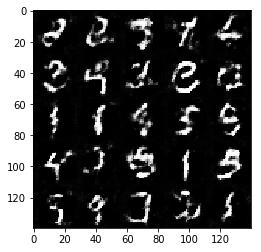

Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 0.9519
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 1.8286
Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 0.9264
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 0.5717
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.9269
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 1.1765
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.5499
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.9699


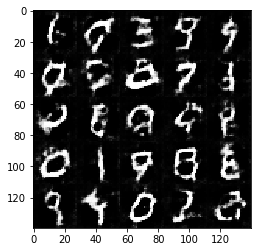

Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 1.6232
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 0.8192
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 0.9566
Epoch 1/2... Discriminator Loss: 1.0560... Generator Loss: 1.2840
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 0.7838
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 1.6740
Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 0.7854
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.7509


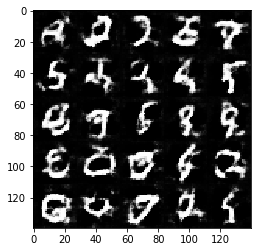

Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.5968
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.1230
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 1.1582
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 1.5646
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 1.0501... Generator Loss: 1.2473
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 0.8678
Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 0.5624
Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 0.9399


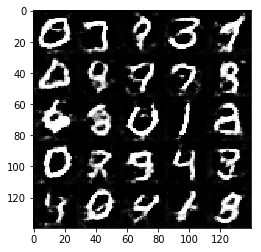

Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 1.2487... Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 1.5526
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.5140
Epoch 1/2... Discriminator Loss: 1.3144... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 1.9361
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.8734
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 1.3011


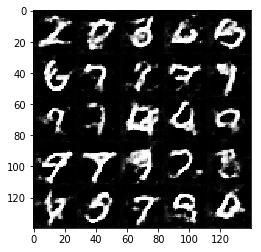

Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.5914
Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.0179... Generator Loss: 0.9693
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.5531
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.5729
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 1.2018
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 1.3514
Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 1.3570
Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 1.3199


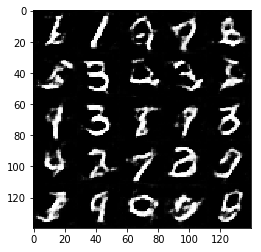

Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 0.9716... Generator Loss: 1.4092
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.5093
Epoch 1/2... Discriminator Loss: 0.8641... Generator Loss: 1.0960
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 1.0145
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.7055


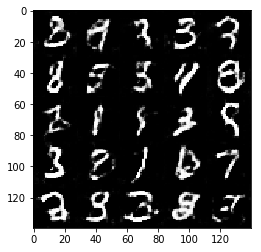

Epoch 1/2... Discriminator Loss: 2.0802... Generator Loss: 0.2616
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.1290
Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 1.6440
Epoch 1/2... Discriminator Loss: 0.9898... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 0.9137... Generator Loss: 1.2280
Epoch 1/2... Discriminator Loss: 1.5715... Generator Loss: 0.4066
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 0.8671... Generator Loss: 1.2021


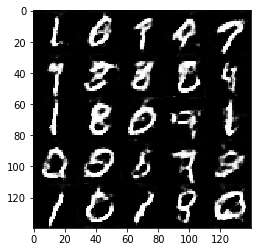

Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 0.9023
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 1.1822
Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 0.9830
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.2217
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 1.3678
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.7647
Epoch 1/2... Discriminator Loss: 0.8260... Generator Loss: 1.1822
Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 1.3923
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 0.6395
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 1.2894


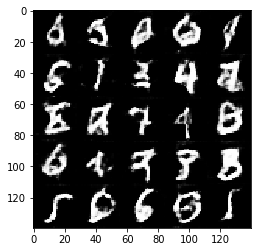

Epoch 1/2... Discriminator Loss: 0.9101... Generator Loss: 1.0925
Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.4482
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.3034
Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 1.2992
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 1.8409
Epoch 1/2... Discriminator Loss: 0.9796... Generator Loss: 1.0121
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 0.7622
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 0.8063... Generator Loss: 1.1548


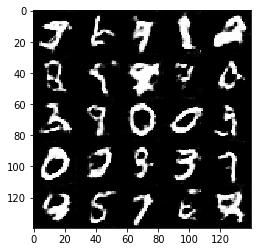

Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 1.8260... Generator Loss: 0.3417
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 0.8109... Generator Loss: 1.1793
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 0.9063
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 0.9775
Epoch 1/2... Discriminator Loss: 0.8567... Generator Loss: 1.6461
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.5591
Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 1.3289


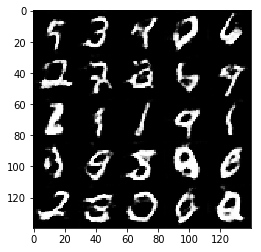

Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 1.2211
Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 0.8484... Generator Loss: 1.1305
Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 1.4119
Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 1.0325
Epoch 1/2... Discriminator Loss: 0.7608... Generator Loss: 1.5146
Epoch 1/2... Discriminator Loss: 0.9780... Generator Loss: 0.8575
Epoch 1/2... Discriminator Loss: 0.8024... Generator Loss: 1.2409
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 0.8164


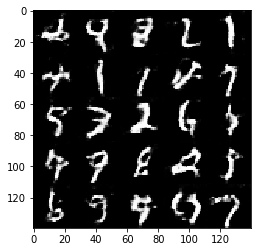

Epoch 1/2... Discriminator Loss: 0.8466... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 4.5678... Generator Loss: 6.1099
Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 1.2801
Epoch 1/2... Discriminator Loss: 0.9096... Generator Loss: 1.0292
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 0.7215... Generator Loss: 1.5905
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.7322
Epoch 1/2... Discriminator Loss: 0.8058... Generator Loss: 1.2144


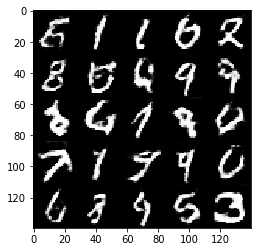

Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.9903
Epoch 1/2... Discriminator Loss: 2.1214... Generator Loss: 0.2394
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.6586
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 0.8226
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 0.9290
Epoch 1/2... Discriminator Loss: 0.8210... Generator Loss: 1.6366
Epoch 1/2... Discriminator Loss: 0.7816... Generator Loss: 1.6712
Epoch 1/2... Discriminator Loss: 0.9057... Generator Loss: 1.0831


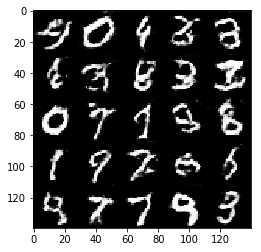

Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 0.8406
Epoch 1/2... Discriminator Loss: 0.6996... Generator Loss: 1.5802
Epoch 1/2... Discriminator Loss: 0.7827... Generator Loss: 1.2057
Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 0.9629
Epoch 1/2... Discriminator Loss: 1.0567... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 0.8880... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 1.2789... Generator Loss: 0.6989


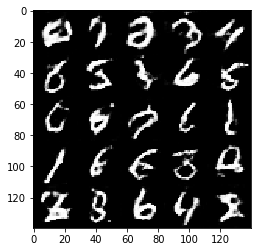

Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 1.8076... Generator Loss: 0.3471
Epoch 2/2... Discriminator Loss: 0.7352... Generator Loss: 1.3045
Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 0.9144
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.5385
Epoch 2/2... Discriminator Loss: 0.7921... Generator Loss: 1.1795
Epoch 2/2... Discriminator Loss: 0.6830... Generator Loss: 1.4270
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 0.9199
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 2.3706
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.9596


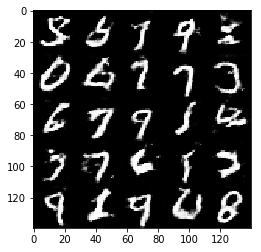

Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 1.0414
Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.5793
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.5013
Epoch 2/2... Discriminator Loss: 0.6514... Generator Loss: 1.6157
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 1.1026
Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 1.1039
Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.9103
Epoch 2/2... Discriminator Loss: 0.7534... Generator Loss: 1.8024
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.3689
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 1.0948


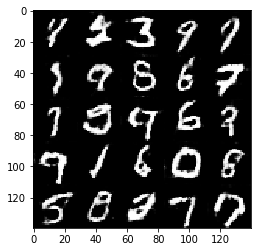

Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 1.0364
Epoch 2/2... Discriminator Loss: 1.5899... Generator Loss: 0.5715
Epoch 2/2... Discriminator Loss: 0.8737... Generator Loss: 1.2139
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 1.7236
Epoch 2/2... Discriminator Loss: 0.8188... Generator Loss: 1.2986
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.5672
Epoch 2/2... Discriminator Loss: 1.1615... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.2630


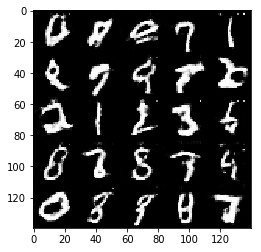

Epoch 2/2... Discriminator Loss: 0.6903... Generator Loss: 1.4304
Epoch 2/2... Discriminator Loss: 0.6539... Generator Loss: 1.4830
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 0.7821... Generator Loss: 1.2917
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 1.2832
Epoch 2/2... Discriminator Loss: 0.8753... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 0.7372
Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 0.8292... Generator Loss: 1.1719


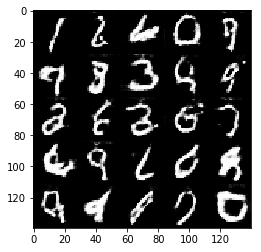

Epoch 2/2... Discriminator Loss: 0.8041... Generator Loss: 2.3862
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 1.0704
Epoch 2/2... Discriminator Loss: 0.9382... Generator Loss: 0.9156
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 1.3402
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.5219
Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 1.3019
Epoch 2/2... Discriminator Loss: 0.6973... Generator Loss: 2.3629
Epoch 2/2... Discriminator Loss: 0.6820... Generator Loss: 1.5505
Epoch 2/2... Discriminator Loss: 0.5180... Generator Loss: 2.2433
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.7452


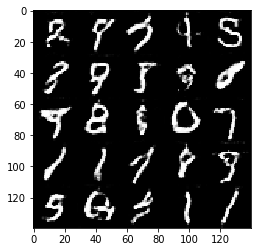

Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 1.1435
Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 1.1305
Epoch 2/2... Discriminator Loss: 1.5960... Generator Loss: 0.5197
Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 1.5142
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 0.7644... Generator Loss: 1.5878
Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 1.1621
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 2.4275


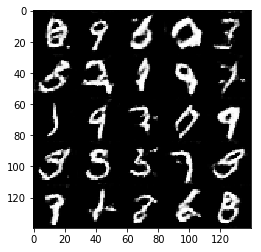

Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 1.4388
Epoch 2/2... Discriminator Loss: 0.5676... Generator Loss: 1.8410
Epoch 2/2... Discriminator Loss: 1.5858... Generator Loss: 0.4221
Epoch 2/2... Discriminator Loss: 0.7513... Generator Loss: 1.2322
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 1.0870
Epoch 2/2... Discriminator Loss: 0.8710... Generator Loss: 1.0811
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 1.2635
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 1.2638
Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 1.2437
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.1538


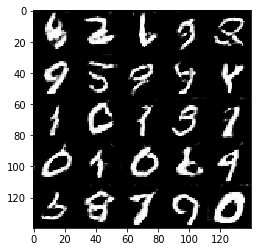

Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 1.7274
Epoch 2/2... Discriminator Loss: 0.8075... Generator Loss: 1.1167
Epoch 2/2... Discriminator Loss: 1.5488... Generator Loss: 0.4901
Epoch 2/2... Discriminator Loss: 1.7282... Generator Loss: 3.0576
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 2.5844
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 1.7402
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.3837
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.2332
Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 1.4864


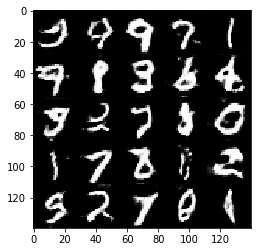

Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 0.9621
Epoch 2/2... Discriminator Loss: 0.7398... Generator Loss: 1.4737
Epoch 2/2... Discriminator Loss: 0.7697... Generator Loss: 1.2445
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.5181
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 0.9707
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.4390
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.6636
Epoch 2/2... Discriminator Loss: 2.1808... Generator Loss: 0.3082
Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 1.4059


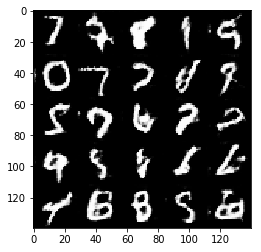

Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 2.1901
Epoch 2/2... Discriminator Loss: 0.6608... Generator Loss: 1.6492
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 0.9859
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.4506
Epoch 2/2... Discriminator Loss: 0.6156... Generator Loss: 1.7589
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 0.9425
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.5386
Epoch 2/2... Discriminator Loss: 0.6603... Generator Loss: 1.5545
Epoch 2/2... Discriminator Loss: 0.7227... Generator Loss: 1.7701
Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.3412


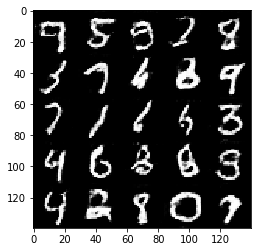

Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 2.1454
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.5292
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 0.6283... Generator Loss: 1.6558
Epoch 2/2... Discriminator Loss: 0.5960... Generator Loss: 1.7533
Epoch 2/2... Discriminator Loss: 0.7724... Generator Loss: 2.0834
Epoch 2/2... Discriminator Loss: 0.6093... Generator Loss: 1.8356
Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 1.8721
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.4837


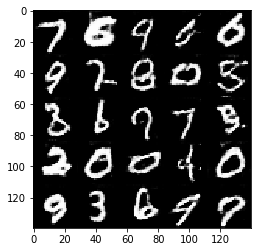

Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.4322
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 0.6463... Generator Loss: 1.6838
Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 2.0058
Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 1.0566
Epoch 2/2... Discriminator Loss: 1.0876... Generator Loss: 2.7857
Epoch 2/2... Discriminator Loss: 0.5818... Generator Loss: 1.8822
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 1.0764
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.4609


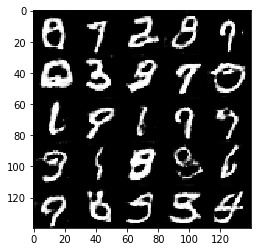

Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 1.0768
Epoch 2/2... Discriminator Loss: 0.5828... Generator Loss: 1.8670
Epoch 2/2... Discriminator Loss: 0.5600... Generator Loss: 2.1670
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.8589
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 0.6365... Generator Loss: 1.5979
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.3837
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.0522
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 1.1508
Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 1.0247


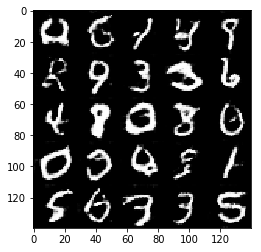

Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 1.3987
Epoch 2/2... Discriminator Loss: 2.3076... Generator Loss: 5.0599
Epoch 2/2... Discriminator Loss: 0.7760... Generator Loss: 1.4796
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.2164
Epoch 2/2... Discriminator Loss: 0.6416... Generator Loss: 2.6568
Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 2.0690
Epoch 2/2... Discriminator Loss: 0.6745... Generator Loss: 1.9014
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 0.9059
Epoch 2/2... Discriminator Loss: 0.6870... Generator Loss: 1.5742
Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 0.6130


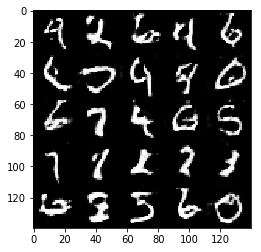

Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.1965
Epoch 2/2... Discriminator Loss: 0.7083... Generator Loss: 2.7044
Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 1.1820
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 1.2700
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.4368
Epoch 2/2... Discriminator Loss: 0.6095... Generator Loss: 1.7137
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 0.9319... Generator Loss: 0.9418
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 1.2165


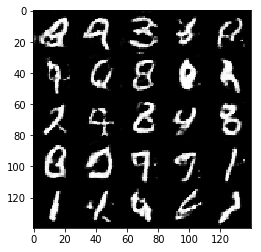

Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 1.3465
Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 1.1589
Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 0.8847
Epoch 2/2... Discriminator Loss: 0.6801... Generator Loss: 1.4671
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 0.5520... Generator Loss: 1.9002
Epoch 2/2... Discriminator Loss: 3.2569... Generator Loss: 0.1385
Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 1.1090
Epoch 2/2... Discriminator Loss: 0.6699... Generator Loss: 1.5820
Epoch 2/2... Discriminator Loss: 0.6256... Generator Loss: 1.6891


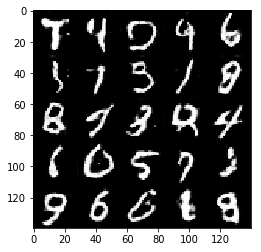

Epoch 2/2... Discriminator Loss: 0.6471... Generator Loss: 1.5159
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 1.3136
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 0.9549
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 1.2659
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.5914
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.5549
Epoch 2/2... Discriminator Loss: 0.7469... Generator Loss: 1.2569
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 1.6214
Epoch 2/2... Discriminator Loss: 0.6613... Generator Loss: 1.5656


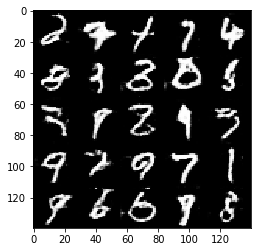

Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 1.2360
Epoch 2/2... Discriminator Loss: 1.7860... Generator Loss: 0.4314
Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 0.7414
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 0.9876
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 1.1322
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 1.7102
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.5073
Epoch 2/2... Discriminator Loss: 0.6220... Generator Loss: 1.6564


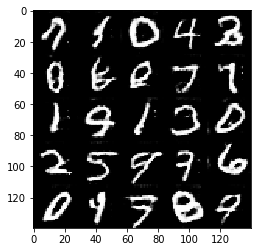

Epoch 2/2... Discriminator Loss: 0.8112... Generator Loss: 1.1613
Epoch 2/2... Discriminator Loss: 0.7214... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 2.5835
Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 1.5561
Epoch 2/2... Discriminator Loss: 0.6344... Generator Loss: 1.6226


In [15]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.9363... Generator Loss: 0.1795
Epoch 1/1... Discriminator Loss: 1.8258... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.5210
Epoch 1/1... Discriminator Loss: 1.8096... Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.4333
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 8.9445
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 1.7452... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.8211
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.9352


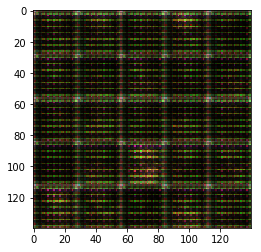

Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.8686
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 2.2463
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.7330
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 2.5631
Epoch 1/1... Discriminator Loss: 2.0636... Generator Loss: 0.2701
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 1.6297... Generator Loss: 0.4742


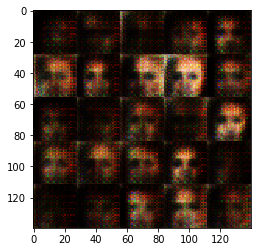

Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.6588
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 2.2337
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.8099... Generator Loss: 0.3311
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.5956


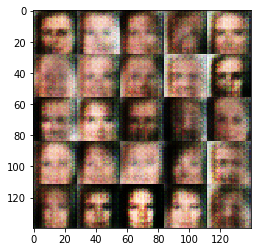

Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.5611
Epoch 1/1... Discriminator Loss: 1.9039... Generator Loss: 0.2986
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.4140
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 1.2517


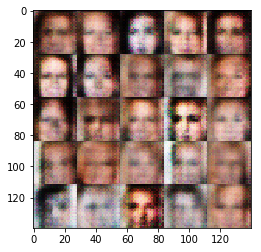

Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.6767... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8901


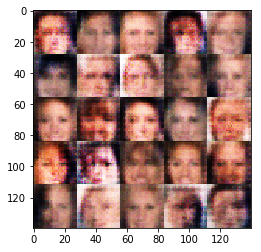

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.6551... Generator Loss: 0.4464
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 1.0005


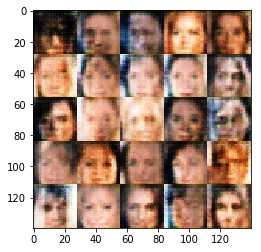

Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 1.1465


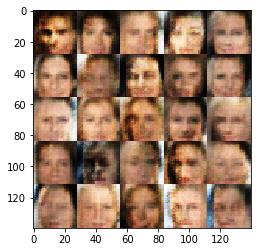

Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7155


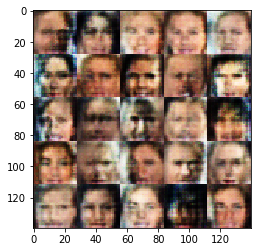

Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.1135


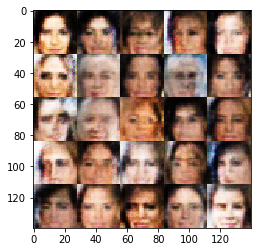

Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6776


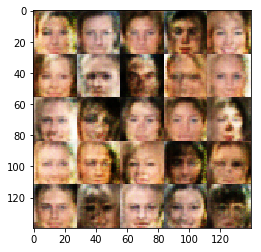

Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6972


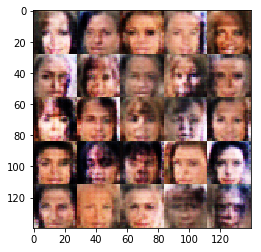

Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.6144


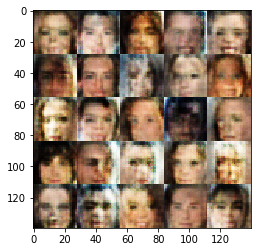

Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.8703


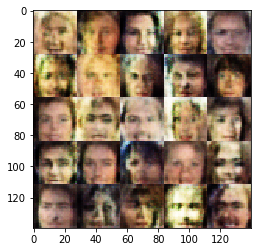

Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7026


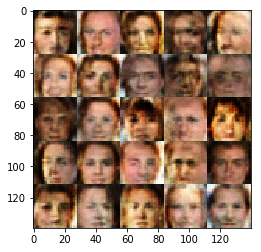

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.9970


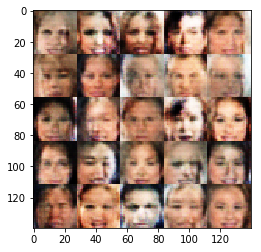

Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8152


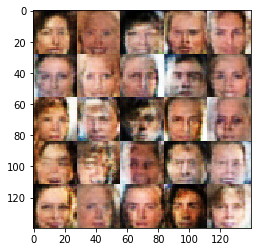

Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.9279


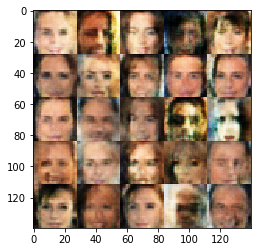

Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.7609


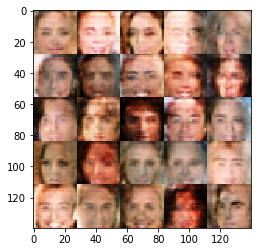

Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7590


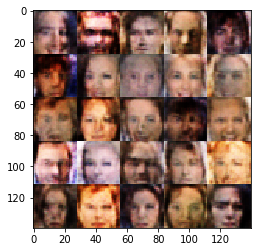

Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8208


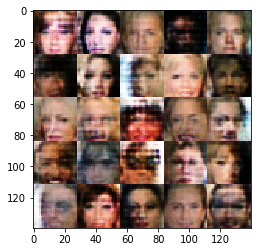

Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.7752


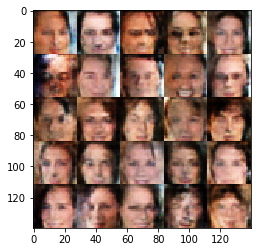

Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 1.0761


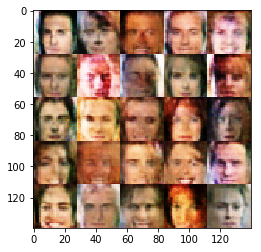

Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.0911


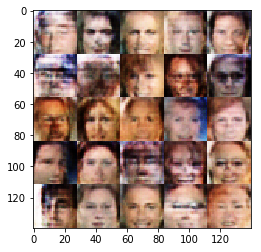

Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6928


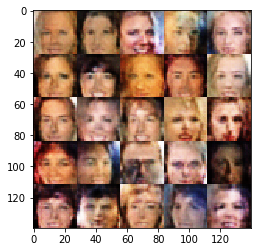

Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6425


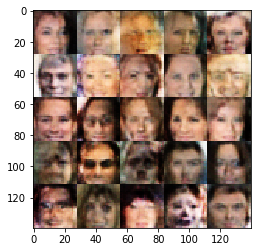

Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6577


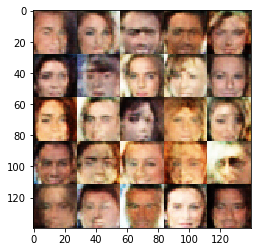

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.2156
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.9386


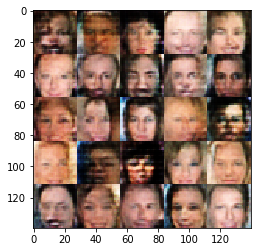

Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.5647


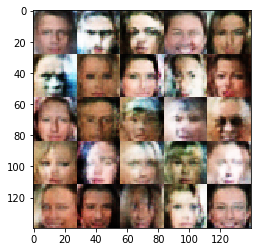

Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 1.0598


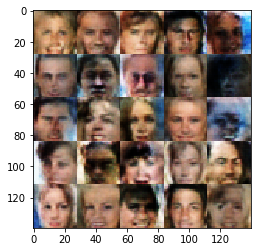

Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.5582


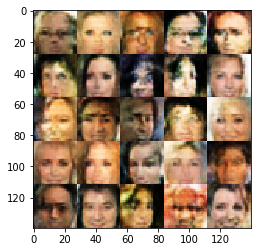

Epoch 1/1... Discriminator Loss: 1.6162... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.0203


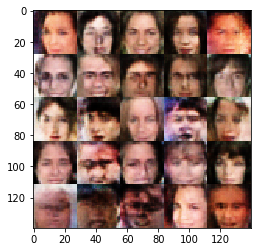

Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.8969


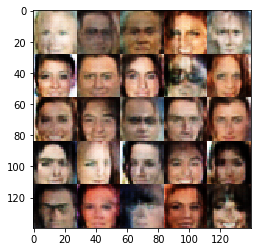

Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 1.7755


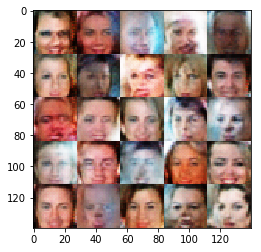

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.5413


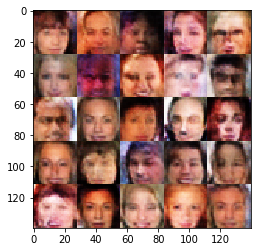

Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.3663
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.7496


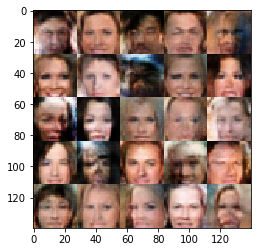

Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.0469


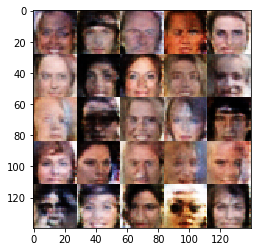

Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.5263
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.9034


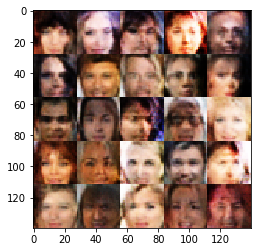

Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.5508


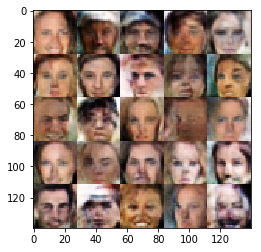

Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.5677


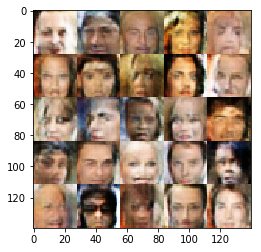

Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7665


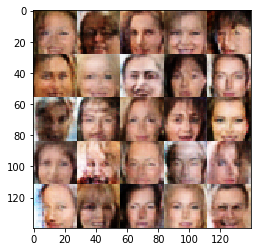

Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.8061


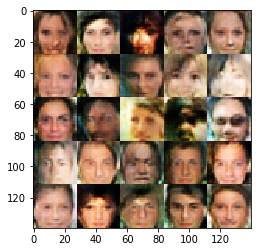

Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.4971


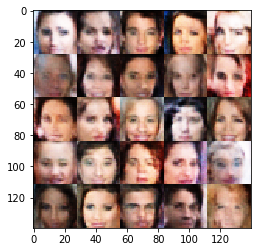

Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.6018... Generator Loss: 0.3994
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6023


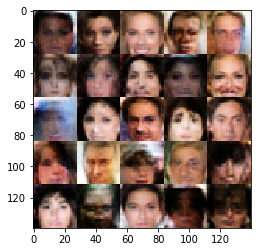

Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 1.5784
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7136


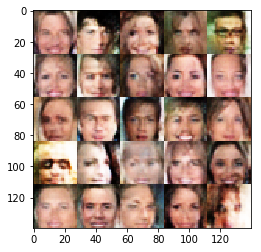

Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.1317
Epoch 1/1... Discriminator Loss: 1.7108... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.9244


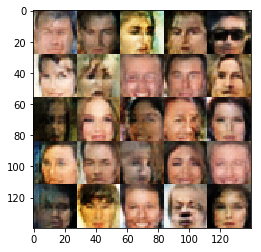

Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.3409
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.9533


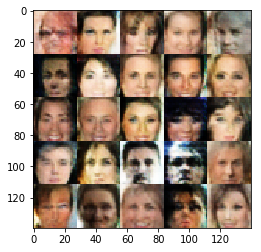

Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.6553


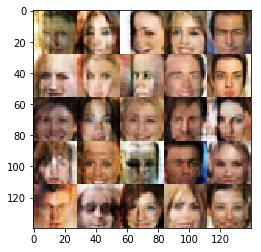

Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.7185... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.3685


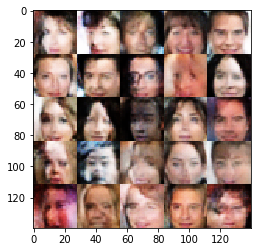

Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.1924
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.8586


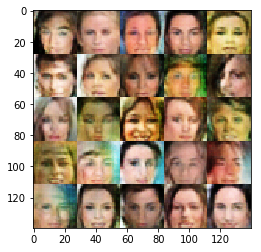

Epoch 1/1... Discriminator Loss: 1.7605... Generator Loss: 0.3497
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.3285
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 1.8364
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.0329


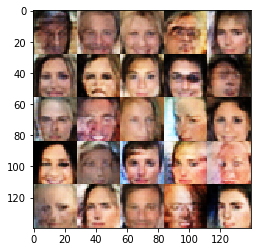

Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.0844
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 2.0677


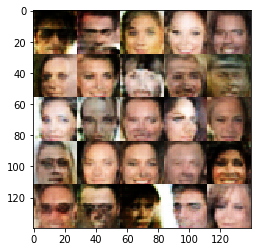

Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.2363
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.7309... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.3867
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 1.8972
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 2.6100
Epoch 1/1... Discriminator Loss: 1.7902... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.1608


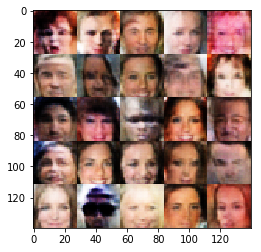

Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.4372
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 2.5786
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.9779


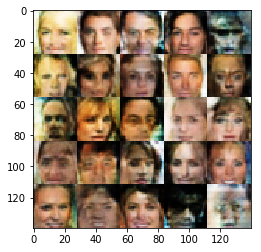

Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 2.0114
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 2.3172
Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 2.4136
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.4178
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 1.7456
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 3.0436
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.7964


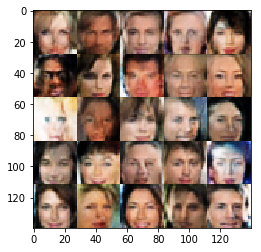

Epoch 1/1... Discriminator Loss: 0.6505... Generator Loss: 1.8783
Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 1.3114
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 1.7608
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.5881
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.5723
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 1.5853
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 2.2723
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 0.9493


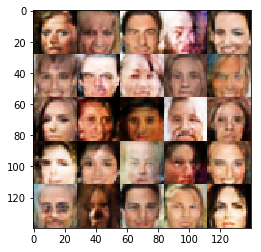

Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.4728
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.0996
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 2.2868... Generator Loss: 2.3917
Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 1.5241
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 2.3494
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 1.6011
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 3.9039
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.4566


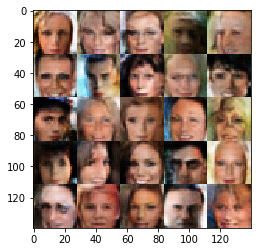

Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.5665
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.3700
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 1.9984


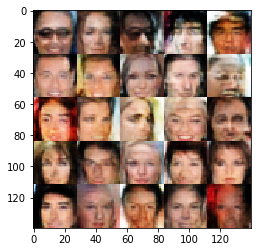

Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 2.4637
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 2.2323
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 2.6256
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.3414
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.6356
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 0.9216


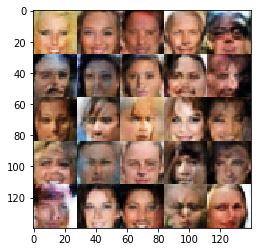

Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 2.7913
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 1.6276
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 1.8450
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.8503
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 2.3493
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 1.9493
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 2.3818


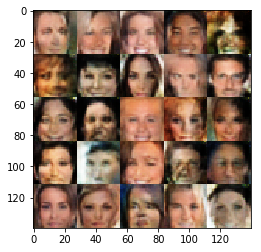

Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 1.5373
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 2.7291
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 0.6886... Generator Loss: 1.3331
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 0.6636... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.0568


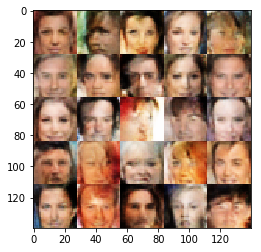

Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 4.0468
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 1.8915
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 2.2658
Epoch 1/1... Discriminator Loss: 0.6050... Generator Loss: 1.7943
Epoch 1/1... Discriminator Loss: 1.7059... Generator Loss: 0.3385
Epoch 1/1... Discriminator Loss: 0.5767... Generator Loss: 1.7232
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.3092
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 5.0408


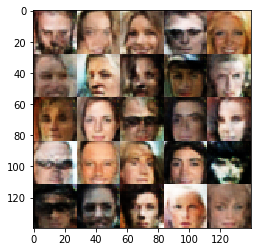

Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 2.5579
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 2.2125
Epoch 1/1... Discriminator Loss: 1.8915... Generator Loss: 3.0033
Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 2.7987
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 1.7351
Epoch 1/1... Discriminator Loss: 0.4328... Generator Loss: 4.1859


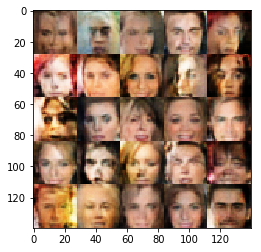

Epoch 1/1... Discriminator Loss: 0.7206... Generator Loss: 1.7485
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 2.0935
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 2.3592
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 2.0215
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.2940
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 2.3322
Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 4.9279
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 1.8582


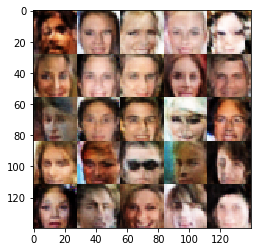

Epoch 1/1... Discriminator Loss: 0.6176... Generator Loss: 1.5732
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 2.0219
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 2.7072


In [16]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.